In [61]:
from pyspark.sql.functions import col, explode
from pyspark import SparkContext
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import pandas as pd

#location of data files
dbfs_dir = 's3://netflix.movie.ratings/'
movieTitles_filename = dbfs_dir + 'movie_titles.txt'
trainingRatings_filename = dbfs_dir + 'TrainingRatings.txt'
testingRatings_filename = dbfs_dir + 'TestingRatings.txt'

In [3]:
#define the schemas

from pyspark.sql.types import *

movieTitles_df_schema = StructType(
  [StructField('MovieID', IntegerType()),
   StructField('YearOfRelease', DateType()),
   StructField('Title', StringType())]
)

trainingRatings_df_schema = StructType(
  [StructField('MovieID', IntegerType()),
   StructField('UserID', IntegerType()),
   StructField('Rating', DoubleType())]
)

testingRatings_df_schema = StructType(
  [StructField('MovieID', IntegerType()),
   StructField('UserID', IntegerType()),
   StructField('Rating', DoubleType())]
)

In [78]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *

raw_movieTitles_df = sqlContext.read.format('csv').options(header=True, inferSchema=False).schema(movieTitles_df_schema).load(movieTitles_filename)
movieTitles_df = raw_movieTitles_df.drop('YearOfRelease')

trainingRatings_df = sqlContext.read.format('csv').options(header=True, inferSchema=False).schema(trainingRatings_df_schema).load(trainingRatings_filename)

testingRatings_df = sqlContext.read.format('csv').options(header=True, inferSchema=False).schema(testingRatings_df_schema).load(testingRatings_filename)

raw_movieTitles_df.cache()
movieTitles_df.cache()
trainingRatings_df.cache()
testingRatings_df.cache()

movies_count = movieTitles_df.count()
trainingRatings_count = trainingRatings_df.count()
testingRatings_count = testingRatings_df.count()

assert raw_movieTitles_df.is_cached
assert movieTitles_df.is_cached
assert trainingRatings_df.is_cached
assert testingRatings_df.is_cached

print ('There are %s movies and %s Training_ratings and %s Testing_ratings in the datasets' % (movies_count, trainingRatings_count, testingRatings_count))

print ('Movies list')
movieTitles_df.show(3, truncate=False)

print ('Training_Ratings list')
trainingRatings_df.show(3, truncate=False)

print ('Testing_Ratings list')
testingRatings_df.show(3, truncate=False)

22/05/03 10:41:36 WARN CacheManager: Asked to cache already cached data.
22/05/03 10:41:36 WARN CacheManager: Asked to cache already cached data.
22/05/03 10:41:36 WARN CacheManager: Asked to cache already cached data.
22/05/03 10:41:36 WARN CacheManager: Asked to cache already cached data.


There are 17769 movies and 3255351 Training_ratings and 100477 Testing_ratings in the datasets
Movies list
+-------+----------------------------+
|MovieID|Title                       |
+-------+----------------------------+
|2      |Isle of Man TT 2004 Review  |
|3      |Character                   |
|4      |Paula Abdul's Get Up & Dance|
+-------+----------------------------+
only showing top 3 rows

Training_Ratings list
+-------+-------+------+
|MovieID|UserID |Rating|
+-------+-------+------+
|8      |1395430|2.0   |
|8      |1205593|4.0   |
|8      |1488844|4.0   |
+-------+-------+------+
only showing top 3 rows

Testing_Ratings list
+-------+-------+------+
|MovieID|UserID |Rating|
+-------+-------+------+
|8      |2149668|3.0   |
|8      |1089184|3.0   |
|8      |2465894|3.0   |
+-------+-------+------+
only showing top 3 rows



In [69]:
train_all_df = trainingRatings_df.join(movieTitles_df, on='MovieID')

In [58]:
# getting the  unique count
unique_movies_count = movieTitles_df.select("MovieID").distinct().count()
print("There are %s distinct_movies in Movie Titles dataset: "% (unique_movies_count))

train_unique_movies_count = trainingRatings_df.select("MovieID").distinct().count()
train_unique_user_count = trainingRatings_df.select("UserID").distinct().count()
train_unique_rating_count = trainingRatings_df.select("Rating").distinct().count()
print ('There are %s distinct_movies and %s distinct_Users and %s distinct_Ratings in the Training dataset' % (train_unique_movies_count, train_unique_user_count, train_unique_rating_count))

test_unique_movies_count = testingRatings_df.select("MovieID").distinct().count()
test_unique_user_count = testingRatings_df.select("UserID").distinct().count()
test_unique_rating_count = testingRatings_df.select("Rating").distinct().count()
print ('There are %s distinct_movies and %s distinct_Users and %s distinct_Ratings in the Testing dataset' % (test_unique_movies_count, test_unique_user_count, test_unique_rating_count))

There are 17769 distinct_movies in Movie Titles dataset: 
There are 1821 distinct_movies and 28978 distinct_Users and 5 distinct_Ratings in the Training dataset
There are 1701 distinct_movies and 27555 distinct_Users and 5 distinct_Ratings in the Testing dataset


# Data Analysis

In [59]:
# Converting to pandas DF
pandas_train_df = trainingRatings_df.toPandas()
pandas_test_df = testingRatings_df.toPandas()


In [100]:
pandas_movies_df = movieTitles_df.toPandas()

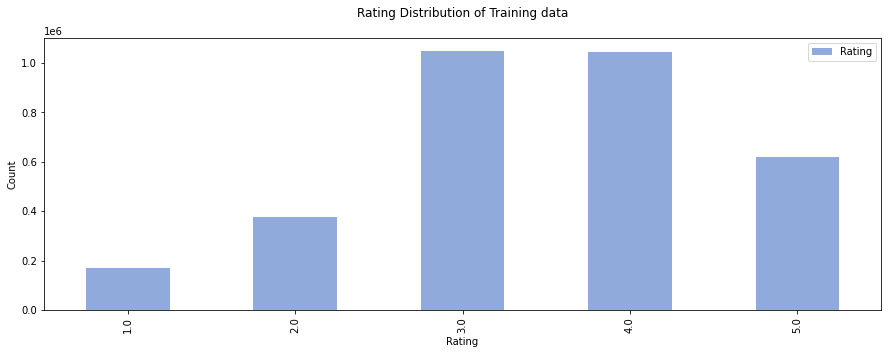

In [63]:
(pd.DataFrame(pandas_train_df['Rating']
              .value_counts(sort=False))
              .sort_index()
              .plot(kind='bar', color='#4472C4', figsize=(15,5), alpha=0.6))
plt.title('Rating Distribution of Training data\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

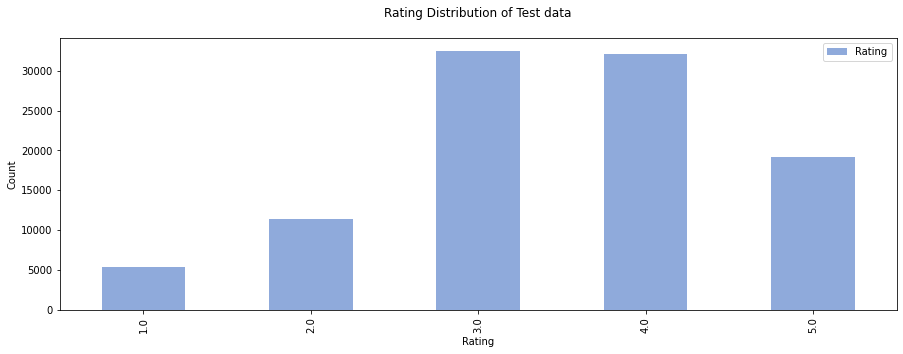

In [64]:
(pd.DataFrame(pandas_test_df['Rating']
              .value_counts(sort=False))
              .sort_index()
              .plot(kind='bar', color='#4472C4', figsize=(15,5), alpha=0.6))
plt.title('Rating Distribution of Test data\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

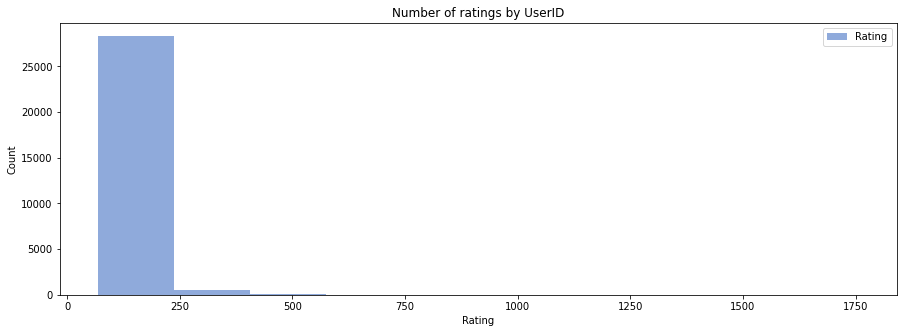

In [107]:
(pd.DataFrame(pandas_train_df.groupby('UserID')
              .count()['Rating'])
              .plot(kind='hist', color='#4472C4', figsize=(15,5), alpha=0.6))
plt.title('Number of ratings by UserID')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

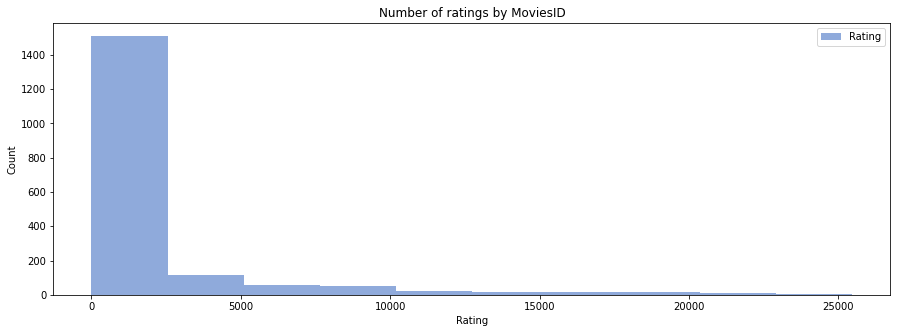

In [108]:
# Reviews per movie plot
(pd.DataFrame(pandas_train_df.groupby('MovieID')
              .count()['Rating'])
              .plot(kind='hist', color='#4472C4', figsize=(15,5), alpha=0.6))
plt.title('Number of ratings by MoviesID')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [65]:
# Rating Distribution
pandas_train_df['Rating'].describe().to_frame()

,Rating
count,3.255351e+06
mean,3.481188e+00
std,1.082873e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [66]:
# Rating Distribution
pandas_test_df['Rating'].describe().to_frame()

,Rating
count,100477.000000
mean,3.479483
std,1.085257
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [67]:
pandas_train_df.groupby('MovieID')['UserID'].count().sort_values(ascending=False).reset_index(name='UserIDCount').head()

,MovieID,UserIDCount
0,6971,25468
1,6287,24393
2,4640,23525
3,9728,23184
4,8596,23005


In [68]:
pandas_test_df.groupby('MovieID')['UserID'].count().sort_values(ascending=False).reset_index(name='UserIDCount').head()

,MovieID,UserIDCount
0,6971,811
1,4640,756
2,6287,737
3,9728,706
4,8915,695


In [84]:
# Obtaining mean rating for every movie
sorted_movies = pandas_train_df.groupby('MovieID').mean()
sorted_movies.sort_values(['Rating'], ascending=False, inplace = True)
top10movies = list(sorted_movies.head(10).index)
bottom10movies = list(sorted_movies.tail(10).index)

DataFrame[MovieID: int, Title: string]

In [103]:
# Top rated movies
pandas_movies_df[pandas_movies_df['MovieID'].isin(top10movies)]

,MovieID,Title
1254,1256,The Best of Friends: Vol. 4
3031,3033,Ghost in the Shell: Stand Alone Complex: 2nd Gig
3288,3290,The Godfather
4236,4238,Inu-Yasha
5758,5760,The Sopranos: Season 3
7567,7569,Dead Like Me: Season 2
12291,12293,The Godfather
14281,14283,The Best of Friends: Vol. 3
14646,14648,Finding Nemo (Full-screen)
16145,16147,The Sopranos: Season 1


In [104]:
# Bottom rated movies
pandas_movies_df[pandas_movies_df['MovieID'].isin(bottom10movies)]

,MovieID,Title
1922,1924,Terror Toons
6361,6363,Hot Wax Zombies on Wheels
7087,7089,Blood Sisters of Lesbian Sin
9694,9696,Fart: The Movie
11684,11686,Da Hip Hop Witch
12885,12887,Legend of the Chupacabra
14738,14740,Seamless
14773,14775,Vicious
15081,15083,Mulva: Zombie Ass Kicker! / Filthy McNasty (Do...
15685,15687,Vampiyaz


In [86]:
# Getting only significant columns for the UIM matrix
uim = pandas_train_df[['UserID', 'MovieID', 'Rating']].copy()
uim.head()

,UserID,MovieID,Rating
0,1395430,8,2.0
1,1205593,8,4.0
2,1488844,8,4.0
3,1447354,8,1.0
4,306466,8,4.0


In [87]:
# Creating UIM matrix using pivot
uim = uim.pivot(index='UserID', columns='MovieID', values='Rating')
uim.head()

MovieID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
UserID,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Filling NA's with 0
uim = uim.fillna(0)
uim.head()

MovieID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
UserID,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
#!pip3 install scikit-learn scipy
from sklearn.metrics.pairwise import cosine_similarity

# Function for finding similar users
# Receives:
# - user: The ratings made by the user to study
# - uim: The User Item Matrix with all other users to calculate similarity
def findSimilarUsers(user, uim):
    similarity = []
    for i,row in enumerate(uim.values):
        cos = cosine_similarity(user, row.reshape(1, -1))[0][0]
        similarity.append([i, cos])
    temp = pd.DataFrame(similarity, columns=['UserID', 'similarity'])
    temp = temp.sort_values(by=['similarity'], ascending=False).copy()
    similar_users = list(temp['UserID'].values)
    similarities = list(temp['similarity'].values)

    return (similar_users, similarities)

In [94]:
# Test user is created by selecting the first user of the UIM matrix
user = uim.iloc[0].values.reshape(1, -1)
temp = findSimilarUsers(user, uim)

In [95]:
# The top 5 similar users are:
temp[0][0:5]

[0, 25579, 22260, 9457, 26442]

In [96]:
# The cosine similarity obtained respectively for that users are:
temp[1][0:5]

[1.0,
 0.5916785801335092,
 0.5813912375803018,
 0.5774919071521013,
 0.5761935191093228]

In [97]:
# Function that returns the most suitable recommendations of movies
# Requires:
# - user: The ratings made by the user to study
# - uim: The User Item Matrix with all other users to calculate similarity
# - recommendations: Number of expected recommendations
# - analyzed_users: Number of similar users to analyze
# - findSimilarUsers: Function that finds similar users from the dataset

def findSimilarMovies(user, uim, recommendations=10, analyzed_users=10):
    # Looking for movies that the user has already seen
    seen = list(uim.columns[list((user>0)[0])])
    
    # Looking for similar users
    similars = findSimilarUsers(user, uim)
    
    # The Dataframe of results is ceated
    scores = pd.DataFrame(columns=['MovieID', 'score'])
    dtypes = np.dtype([
          ('MovieID', int),          
          ('score', float),          
          ])

    # For the top similar users (analyzed users) the process gets repeated
    for sim_user, sim_score in zip(similars[0][0:analyzed_users], similars[1][0:analyzed_users]):
        # Dropping movies that the studied user has already seen
        rec_movies = uim.iloc[sim_user].drop(seen)
        # Dropping low rated movies
        rec_index = list(rec_movies[rec_movies>4].index.values)        
        
        if (len(rec_index)>0):
            # For every recommended movies of a particualar similar user:
            for movie in rec_index:
                # If the movie is not in the dataframe, it will add it to the dataframe
                if (movie not in scores['MovieID'].values):
                    scores.loc[len(scores)] = (movie, 10*sim_score)
                else: 
                # If the movies is already in the dataframe , it will increase its score
                    scores.loc[scores['MovieID']==movie, 'score'] += 10*sim_score
        # The values are sorted by the score obtained
        scores.sort_values(by='score', ascending=False, inplace=True)
        
        # There could the case that not enough users are similar
        try:
            scores = scores.head(recommendations)
            scores['MovieID'] = scores['MovieID'].astype(int)
        except:
            scores['MovieID'] = scores['MovieID'].astype(int)
    
    # The movie id's and their corresponding scores are returned in lists
    return (list(scores.MovieID.values), list(scores.score.values))   

In [98]:
# movie Id and Score obtained for that recommendation
ids, scores = findSimilarMovies(user, uim)    
pd.DataFrame({'MovieID': ids, 'Score': scores})

,MovieID,Score
0,12280,23.003437
1,13636,17.286390
2,11812,17.247149
3,442,11.588831
4,13015,11.552155
5,7569,5.916786
6,13477,5.813912
7,11888,5.813912
8,9798,5.813912
9,13614,5.694994


In [101]:
# Looking for what movies belong to those movie ids
pandas_movies_df[pandas_movies_df['MovieID'].isin(ids)]

,MovieID,Title
440,442,Mississippi Burning
7567,7569,Dead Like Me: Season 2
9796,9798,A Civil Action
11810,11812,Million Dollar Baby
11886,11888,In the Line of Fire
12278,12280,The Jerk
13013,13015,The Lost Boys: Special Edition
13475,13477,Stephen King's The Shining
13612,13614,Office Space
13634,13636,Fast Times at Ridgemont High


In [2]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

In [15]:
#taking more time to execute for Training Dataset so given splitted validation data as input
seed = 99
(sample_train_df, sample_test_df, sample_val_df) = testingRatings_df.randomSplit([6.0, 2.0, 2.0], seed)

# Let's cache these datasets for performance
sample_training_df = sample_train_df.cache()
sample_validation_df = sample_val_df.cache()
sample_test_df = sample_test_df.cache()

print('Training: {0}, validation: {1}, test: {2}\n'.format(
  sample_training_df.count(), sample_validation_df.count(), sample_test_df.count())
)

#pandasDF = trainingRatings_df.toPandas()
pandasDF = sample_test_df.toPandas()  #taking more time to execute so given validation data as input
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(pandasDF,reader)

22/05/03 08:29:18 WARN CacheManager: Asked to cache already cached data.
22/05/03 08:29:18 WARN CacheManager: Asked to cache already cached data.
22/05/03 08:29:18 WARN CacheManager: Asked to cache already cached data.


Training: 60335, validation: 20264, test: 19878



In [16]:
#Item Based approach
sim_options = {
    'name': 'pearson',
    'user_based': 'False'
}

clf = KNNBasic(sim_options = sim_options)
cross_validate(clf, dataset, measures=['RMSE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0836  1.0637  1.0729  1.0905  1.0953  1.0812  0.0115  
Fit time          0.04    0.03    0.02    0.03    0.02    0.03    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([1.08357518, 1.06373031, 1.07291963, 1.0904588 , 1.09529248]),
 'fit_time': (0.038956642150878906,
  0.02957749366760254,
  0.022879362106323242,
  0.026577472686767578,
  0.024404525756835938),
 'test_time': (0.01745152473449707,
  0.018187284469604492,
  0.018151283264160156,
  0.018984079360961914,
  0.018859386444091797)}

In [17]:
#User Based approach
sim_options = {
    'name': 'MSD',
    'user_based': 'True'
}

clf = KNNBasic(sim_options = sim_options)
cross_validate(clf, dataset, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1080  1.0795  1.0945  1.0978  1.1020  1.0964  0.0096  
Fit time          0.02    0.02    0.02    0.01    0.02    0.02    0.00    
Test time         0.02    0.02    0.02    0.02    0.05    0.02    0.01    


{'test_rmse': array([1.10803896, 1.07948551, 1.09445181, 1.09776033, 1.10202666]),
 'fit_time': (0.02236151695251465,
  0.016630172729492188,
  0.01509547233581543,
  0.014615297317504883,
  0.017407894134521484),
 'test_time': (0.018701553344726562,
  0.017722606658935547,
  0.017951488494873047,
  0.018004655838012695,
  0.05188584327697754)}

In [7]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ALS model
als = ALS(
         maxIter=10,
         userCol="UserID", 
         itemCol="MovieID",
         ratingCol="Rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [8]:
# Import the requisite packages
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

ParamGridBuilder: We will first define the tuning parameter using param_grid function, please feel free experiment with parameters for the grid. I have only chosen 4 parameters for each grid. This will result in 16 models for training.# 

In [9]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 20, 50,]) \
            .addGrid(als.regParam, [.01, .05, .1, ]) \
            .build()
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  9


# RegressionEvaluator

 Define the evaluator, select rmse as metricName in evaluator.

In [10]:
# Define evaluator as RMSE 
rmse_evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="Rating", 
           predictionCol="prediction") 

In [11]:
# Define evaluator as MSE
mse_evaluator = RegressionEvaluator(
           metricName="mse", 
           labelCol="Rating", 
           predictionCol="prediction") 

In [12]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=rmse_evaluator, numFolds=5)

In [13]:
#Fit cross validator to the 'train' dataset
model = cv.fit(trainingRatings_df)


In [14]:
#Extract best model from the cv model above
best_model = model.bestModel
print("**Best Model**")
# Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())
# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

**Best Model**
  Rank: 20
  MaxIter: 10
  RegParam: 0.05


In [15]:
# View the predictions
test_predictions = best_model.transform(testingRatings_df)

In [16]:
print("Model Predicted Ratings on Test data : \n")  
test_predictions.show(5, truncate=False)

Model Predicted Ratings on Test data : 

+-------+-------+------+----------+
|MovieID|UserID |Rating|prediction|
+-------+-------+------+----------+
|28     |2358799|3.0   |3.861073  |
|156    |973051 |5.0   |4.066124  |
|851    |1189060|3.0   |3.5445638 |
|1100   |2376892|2.0   |2.2553442 |
|1123   |1628484|3.0   |3.4171214 |
+-------+-------+------+----------+
only showing top 5 rows



In [17]:
RMSE = rmse_evaluator.evaluate(test_predictions)
print('RMSE Error on Test data : ', RMSE)

[Stage 4065:========================================>           (155 + 8) / 200]

RMSE Error on Test data :  0.8356966096190834


In [18]:

MSE = mse_evaluator.evaluate(test_predictions)
print('MSE Error on Test data : ', MSE)

[Stage 4095:===================================>                (136 + 8) / 200]

MSE Error on Test data :  0.6983888233288308


In [19]:
# Generate n Recommendations for all users n = 10
recommendations = best_model.recommendForAllUsers(10)
recommendations.show()

[Stage 4121:====================================================>(99 + 1) / 100]

+------+--------------------+
|UserID|     recommendations|
+------+--------------------+
|   481|[[7569, 5.200222]...|
|  2678|[[12421, 4.433958...|
|  3595|[[12293, 4.726034...|
|  6460|[[9973, 4.8176937...|
|  7284|[[7016, 5.561732]...|
|  7576|[[6522, 5.0784793...|
|  9597|[[15480, 4.309165...|
| 15191|[[6287, 4.7901707...|
| 15846|[[16147, 5.028747...|
| 20461|[[14283, 4.715459...|
| 20774|[[6991, 4.236231]...|
| 26258|[[1256, 4.410603]...|
| 27608|[[6991, 4.792004]...|
| 28346|[[17085, 4.641161...|
| 30941|[[6991, 5.4102864...|
| 30976|[[1256, 4.9180794...|
| 31203|[[12293, 4.52064]...|
| 36822|[[6287, 5.7062845...|
| 40851|[[17515, 4.41642]...|
| 41068|[[12293, 4.10149]...|
+------+--------------------+
only showing top 20 rows



In [20]:
nrecommendations = recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('UserID', col("rec_exp.MovieID"), col("rec_exp.Rating"))

nrecommendations.limit(10).show()

[Stage 4172:==================================================>  (96 + 4) / 100]

+------+-------+---------+
|UserID|MovieID|   Rating|
+------+-------+---------+
|   481|   7569| 5.200222|
|   481|   7916|5.0914083|
|   481|  16559|5.0560937|
|   481|   6991|4.9898877|
|   481|   5813| 4.933182|
|   481|   2985|4.9163003|
|   481|  14648|4.9094286|
|   481|   7382|  4.88799|
|   481|  17515| 4.882816|
|   481|   4238|4.8812647|
+------+-------+---------+



In [ ]:
#movieTitles_df.show(3)

In [21]:
total_rec_df = nrecommendations.join(movieTitles_df, on='MovieID')
total_rec_df.show(10)

[Stage 4251:=================================================>   (94 + 6) / 100]

+-------+------+---------+--------------------+
|MovieID|UserID|   Rating|               Title|
+-------+------+---------+--------------------+
|   7569|   481| 5.200222|Dead Like Me: Sea...|
|   7916|   481|5.0914083|Tibetan Book of t...|
|  16559|   481|5.0560937|Red Green: Stuffe...|
|   6991|   481|4.9898877|    A History of God|
|   5813|   481| 4.933182|Diana Krall: Live...|
|   2985|   481|4.9163003|There's Something...|
|  14648|   481|4.9094286|Finding Nemo (Ful...|
|   7382|   481|  4.88799|WWE: Tombstone: T...|
|  17515|   481| 4.882816|LeapFrog: Letter ...|
|   4238|   481|4.8812647|           Inu-Yasha|
+-------+------+---------+--------------------+
only showing top 10 rows



In [22]:
total_rec_df.filter('UserId = 2678').sort('Rating', ascending=False).limit(10).show()

[Stage 4303:===================================================> (98 + 2) / 100]

+-------+------+---------+--------------------+
|MovieID|UserID|   Rating|               Title|
+-------+------+---------+--------------------+
|  12421|  2678|4.4339585|        The Crusades|
|  15480|  2678|4.3982887|Farscape: The Pea...|
|  12125|  2678|4.3975625|The Blue Planet: ...|
|  12544|  2678|4.3677964|Peter Gabriel: Pl...|
|   4238|  2678|4.3015156|           Inu-Yasha|
|   7283|  2678|4.2696924|Due South: Call o...|
|  10947|  2678| 4.256988|     The Incredibles|
|  17515|  2678|4.2543573|LeapFrog: Letter ...|
|   2160|  2678| 4.209249|Magnetic Storm: Nova|
|   7505|  2678| 4.186874|Fushigi Yugi: The...|
+-------+------+---------+--------------------+



In [23]:
total_rec_df.filter('UserId = 481').sort('Rating', ascending=False).limit(10).show()

[Stage 4355:==========>  (83 + 8) / 100][Stage 4356:>               (0 + 0) / 1]

+-------+------+---------+--------------------+
|MovieID|UserID|   Rating|               Title|
+-------+------+---------+--------------------+
|   7569|   481| 5.200222|Dead Like Me: Sea...|
|   7916|   481|5.0914083|Tibetan Book of t...|
|  16559|   481|5.0560937|Red Green: Stuffe...|
|   6991|   481|4.9898877|    A History of God|
|   5813|   481| 4.933182|Diana Krall: Live...|
|   2985|   481|4.9163003|There's Something...|
|  14648|   481|4.9094286|Finding Nemo (Ful...|
|   7382|   481|  4.88799|WWE: Tombstone: T...|
|  17515|   481| 4.882816|LeapFrog: Letter ...|
|   4238|   481|4.8812647|           Inu-Yasha|
+-------+------+---------+--------------------+



In [24]:
total_rec_df.filter('UserId = 1395430').sort('Rating', ascending=False).limit(10).show()

[Stage 4409:==============================================>      (88 + 8) / 100]

+-------+-------+---------+--------------------+
|MovieID| UserID|   Rating|               Title|
+-------+-------+---------+--------------------+
|   6991|1395430|4.5091014|    A History of God|
|  12232|1395430|4.1886826| Lost in Translation|
|  10943|1395430| 4.161899|Ben Folds Five: C...|
|  10743|1395430|4.0438566|Pearl Jam: Tourin...|
|   8933|1395430| 4.035455|Ikiru: Bonus Mate...|
|   2355|1395430|4.0132585|Berlin: Symphony ...|
|  12125|1395430| 3.998653|The Blue Planet: ...|
|   3742|1395430|3.9916058|           Notorious|
|   7823|1395430|3.9832985|Monty Python's Th...|
|   6522|1395430|3.9576068|Trailer Park Boys...|
+-------+-------+---------+--------------------+



In [25]:
# SAVE ALS model
als.save('./als_model')
# SAVE Cross validation model
model.save('./cv_model')

# My Ratings Predictions

In [47]:
from pyspark.sql import Row
my_user_id = 5000

testingRatings_df_schema = StructType(
  [StructField('MovieID', IntegerType()),
   StructField('UserID', IntegerType()),
   StructField('Rating', DoubleType())]
)
# Note that the movie IDs are the *last* number on each line. A common error was to use the number of ratings as the movie ID.
# The format of each line is (my_user_id, movie ID, your rating)
my_rated_movies = [
             (6991,my_user_id,5.0),
             (12232,my_user_id,3.0),
             (7569,my_user_id,2.5),
             (16559,my_user_id,4.0),
             (8933,my_user_id,1.8),
             (2355,my_user_id,4.6),
             (12125,my_user_id,1.0),
             (2160,my_user_id,2.0),
             (209,my_user_id,3.0),
             (17515,my_user_id,3.5),
             (2985,my_user_id,0.0),
             (28,my_user_id,5.0),
             (1100,my_user_id,3.0),
             (4238,my_user_id,4.0),
             (7283,my_user_id,2.0),
             (6522,my_user_id,1.0),
             (15040,my_user_id,3.5),
             (3151,my_user_id,4.5),
             (218,my_user_id,2.5),
             (7016,my_user_id,1.5),
             (15567,my_user_id,1.8),
             (9701,my_user_id,2.8),
             (4963,my_user_id,3.0),
             (4,my_user_id,5.0),
             (1, my_user_id,4.6),
            
]
        
my_ratings_df = sqlContext.createDataFrame(my_rated_movies, schema=testingRatings_df_schema)
my_ratings_df.cache()
seed = 1999
my_train_df, my_test_df, my_val_df = my_ratings_df.randomSplit([6.0, 3.0, 1.0], seed)
my_test_df = my_test_df.union(my_val_df)

my_train_df.cache()
my_test_df.cache()

my_movies_df = my_ratings_df.join(movieTitles_df, on='MovieID')
my_movies_df.show()

+-------+------+------+--------------------+
|MovieID|UserID|Rating|               Title|
+-------+------+------+--------------------+
|   6991|  5000|   5.0|    A History of God|
|  12232|  5000|   3.0| Lost in Translation|
|   7569|  5000|   2.5|Dead Like Me: Sea...|
|  16559|  5000|   4.0|Red Green: Stuffe...|
|   8933|  5000|   1.8|Ikiru: Bonus Mate...|
|   2355|  5000|   4.6|Berlin: Symphony ...|
|  12125|  5000|   1.0|The Blue Planet: ...|
|   2160|  5000|   2.0|Magnetic Storm: Nova|
|    209|  5000|   3.0|Star Trek: Deep S...|
|  17515|  5000|   3.5|LeapFrog: Letter ...|
|   2985|  5000|   0.0|There's Something...|
|     28|  5000|   5.0|     Lilo and Stitch|
|   1100|  5000|   3.0|   Dr. T & the Women|
|   4238|  5000|   4.0|           Inu-Yasha|
|   7283|  5000|   2.0|Due South: Call o...|
|   6522|  5000|   1.0|Trailer Park Boys...|
|  15040|  5000|   3.5|Rage Against the ...|
|   3151|  5000|   4.5|   Napoleon Dynamite|
|    218|  5000|   2.5|Triumph: Live at ...|
|   7016| 

In [36]:
my_ratings_df.show()

+-------+------+------+
|MovieID|UserID|Rating|
+-------+------+------+
|   6991|  5000|   5.0|
|  12232|  5000|   3.0|
|   7569|  5000|   2.5|
|  16559|  5000|   4.0|
|   8933|  5000|   1.8|
|   2355|  5000|   4.6|
|  12125|  5000|   1.0|
|   2160|  5000|   2.0|
|    209|  5000|   3.0|
|  17515|  5000|   3.5|
|   2985|  5000|   0.0|
|     28|  5000|   5.0|
|   1100|  5000|   3.0|
|   4238|  5000|   4.0|
|   7283|  5000|   2.0|
|   6522|  5000|   1.0|
|  15040|  5000|   3.5|
|   3151|  5000|   4.5|
|    218|  5000|   2.5|
|   7016|  5000|   1.5|
+-------+------+------+
only showing top 20 rows



In [48]:
my_train_df.show()

+-------+------+------+
|MovieID|UserID|Rating|
+-------+------+------+
|   7569|  5000|   2.5|
|   2355|  5000|   4.6|
|   8933|  5000|   1.8|
|  16559|  5000|   4.0|
|    209|  5000|   3.0|
|   2160|  5000|   2.0|
|  12125|  5000|   1.0|
|   2985|  5000|   0.0|
|  17515|  5000|   3.5|
|   7283|  5000|   2.0|
|   3151|  5000|   4.5|
|   6522|  5000|   1.0|
|   7016|  5000|   1.5|
|  15567|  5000|   1.8|
|      4|  5000|   5.0|
|   4963|  5000|   3.0|
|   9701|  5000|   2.8|
+-------+------+------+



In [49]:
my_test_df.show()

+-------+------+------+
|MovieID|UserID|Rating|
+-------+------+------+
|   6991|  5000|   5.0|
|  12232|  5000|   3.0|
|     28|  5000|   5.0|
|   1100|  5000|   3.0|
|   4238|  5000|   4.0|
|  15040|  5000|   3.5|
|    218|  5000|   2.5|
|      1|  5000|   4.6|
+-------+------+------+



In [50]:
# union the above created dataframes
my_train_df = my_ratings_df.union(trainingRatings_df)
# display
my_train_df.show(20)

+-------+------+------+
|MovieID|UserID|Rating|
+-------+------+------+
|   6991|  5000|   5.0|
|  12232|  5000|   3.0|
|   7569|  5000|   2.5|
|  16559|  5000|   4.0|
|   8933|  5000|   1.8|
|   2355|  5000|   4.6|
|  12125|  5000|   1.0|
|   2160|  5000|   2.0|
|    209|  5000|   3.0|
|  17515|  5000|   3.5|
|   2985|  5000|   0.0|
|     28|  5000|   5.0|
|   1100|  5000|   3.0|
|   4238|  5000|   4.0|
|   7283|  5000|   2.0|
|   6522|  5000|   1.0|
|  15040|  5000|   3.5|
|   3151|  5000|   4.5|
|    218|  5000|   2.5|
|   7016|  5000|   1.5|
+-------+------+------+
only showing top 20 rows



In [39]:
my_als = ALS(
         rank=20, maxIter=10, regParam=0.05, 
         userCol="UserID", 
         itemCol="MovieID",
         ratingCol="Rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [51]:
# Create the model with my parameters.
my_als_model = my_als.fit(my_train_df)

In [52]:
my_test_predictions = my_als_model.transform(my_test_df)
my_rmse_error = rmse_evaluator.evaluate(my_test_predictions)
print("RMS error on the new data : ", my_rmse_error)

RMS error on the new data :  0.841859705031669


In [53]:
print("My Predicted Ratings : \n")  
my_test_predictions.show()

My Predicted Ratings : 

+-------+------+------+----------+
|MovieID|UserID|Rating|prediction|
+-------+------+------+----------+
|   6991|  5000|   5.0|  5.012259|
|  12232|  5000|   3.0| 2.9726129|
|     28|  5000|   5.0| 2.8954036|
|   1100|  5000|   3.0| 2.1100981|
|   4238|  5000|   4.0|  3.812706|
|  15040|  5000|   3.5| 2.8930554|
|    218|  5000|   2.5| 2.7054677|
|      1|  5000|   4.6| 4.5553594|
+-------+------+------+----------+



In [54]:
# Generate n Recommendations for all users n = 10
my_recommendations = my_als_model.recommendForAllUsers(10)
my_recommendations = my_recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('UserID', col("rec_exp.MovieID"), col("rec_exp.Rating"))
my_rec_df = my_recommendations.join(movieTitles_df, on='MovieID')
my_rec_df.filter('UserId = '+str(my_user_id)).sort('Rating', ascending=False).limit(10).show()

+-------+------+---------+--------------------+
|MovieID|UserID|   Rating|               Title|
+-------+------+---------+--------------------+
|   6991|  5000| 5.012259|    A History of God|
|      4|  5000|4.9514775|Paula Abdul's Get...|
|   2756|  5000| 4.798466|         Tenchi Muyo|
|   4918|  5000|4.6848273|Slayers Try DVD C...|
|   8919|  5000| 4.660586|   Cardcaptor Sakura|
|   6619|  5000| 4.568393|Slayers Next DVD ...|
|  10777|  5000| 4.393004|Battle Athletes V...|
|   5484|  5000|4.2430744|Har dil jo Pyar k...|
|   6629|  5000| 4.231745|Legend of the Dra...|
+-------+------+---------+--------------------+

